**Dependencies and setup**

This can take a minute or so...

In [3]:
%%capture
# !apt update
# !apt install xvfb -y
# !pip install 'swig'
# !pip install 'pyglet==1.5.27'
# !pip install 'gym[box2d]==0.20.0'
# !pip install 'pyvirtualdisplay==3.0'

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 100 # videos can take a very long time to render so only do it every N episodes

**Reinforcement learning agent**

Replace this with your own agent - I recommend starting with TD3 (lecture 8)

In [2]:
# class Agent(nn.Module):
#     def __init__(self):
#         super(Agent, self).__init__()

#     def sample_action(self, s):
#         return np.random.uniform(-1.0, 1.0, size=act_dim)

#     def train(self):
#         return

In [4]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Beta,Normal
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, net_width, maxaction):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, action_dim)

		self.maxaction = maxaction

	def forward(self, state):
		a = torch.tanh(self.l1(state))
		a = torch.tanh(self.l2(a))
		a = torch.tanh(self.l3(a)) * self.maxaction
		return a


class Q_Critic(nn.Module):
	def __init__(self, state_dim, action_dim, net_width):
		super(Q_Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, net_width)
		self.l2 = nn.Linear(net_width, net_width)
		self.l3 = nn.Linear(net_width, 1)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, net_width)
		self.l5 = nn.Linear(net_width, net_width)
		self.l6 = nn.Linear(net_width, 1)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1



class Agent(object):
	def __init__(
		self,
		env_with_Dead,
		state_dim,
		action_dim,
		max_action,
		gamma=0.99,
		net_width=128,
		a_lr=1e-4,
		c_lr=1e-4,
		Q_batchsize = 256
	):

		self.actor = Actor(state_dim, action_dim, net_width, max_action).to(device)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=a_lr)
		self.actor_target = copy.deepcopy(self.actor)

		self.q_critic = Q_Critic(state_dim, action_dim, net_width).to(device)
		self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=c_lr)
		self.q_critic_target = copy.deepcopy(self.q_critic)

		self.env_with_Dead = env_with_Dead
		self.action_dim = action_dim
		self.max_action = max_action
		self.gamma = gamma
		self.policy_noise = 0.2*max_action
		self.noise_clip = 0.5*max_action
		self.tau = 0.005
		self.Q_batchsize = Q_batchsize
		self.delay_counter = -1
		self.delay_freq = 1

	def sample_action(self, state):#only used when interact with the env
		with torch.no_grad():
			state = torch.FloatTensor(state.reshape(1, -1)).to(device)
			a = self.actor(state)
		return a.cpu().numpy().flatten()

	def train(self,replay_buffer):
		self.delay_counter += 1
		with torch.no_grad():
			s, a, r, s_prime, dead_mask = replay_buffer.sample(self.Q_batchsize)
			noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
			smoothed_target_a = (
					self.actor_target(s_prime) + noise  # Noisy on target action
			).clamp(-self.max_action, self.max_action)

		# Compute the target Q value
		target_Q1, target_Q2 = self.q_critic_target(s_prime, smoothed_target_a)
		target_Q = torch.min(target_Q1, target_Q2)
		'''DEAD OR NOT'''
		if self.env_with_Dead:
			target_Q = r + (1 - dead_mask) * self.gamma * target_Q  # env with dead
		else:
			target_Q = r + self.gamma * target_Q  # env without dead


		# Get current Q estimates
		current_Q1, current_Q2 = self.q_critic(s, a)

		# Compute critic loss
		q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the q_critic
		self.q_critic_optimizer.zero_grad()
		q_loss.backward()
		self.q_critic_optimizer.step()

		if self.delay_counter == self.delay_freq:
			# Update Actor
			a_loss = -self.q_critic.Q1(s,self.actor(s)).mean()
			self.actor_optimizer.zero_grad()
			a_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			self.delay_counter = -1


	def save(self,episode):
		torch.save(self.actor.state_dict(), "ppo_actor{}.pth".format(episode))
		torch.save(self.q_critic.state_dict(), "ppo_q_critic{}.pth".format(episode))


	def load(self,episode):

		self.actor.load_state_dict(torch.load("ppo_actor{}.pth".format(episode)))
		self.q_critic.load_state_dict(torch.load("ppo_q_critic{}.pth".format(episode)))

**Prepare the environment and wrap it to capture videos**

In [5]:
%%capture
# env = gym.make("BipedalWalker-v3")
env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video_hard", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [5]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu


In [6]:
import numpy as np
import torch


class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.reward = np.zeros((max_size, 1))
		self.next_state = np.zeros((max_size, state_dim))
		self.dead = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, reward, next_state, dead):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.reward[self.ptr] = reward
		self.next_state[self.ptr] = next_state
		self.dead[self.ptr] = dead #0,0,0，...，1

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.dead[ind]).to(self.device)
		)

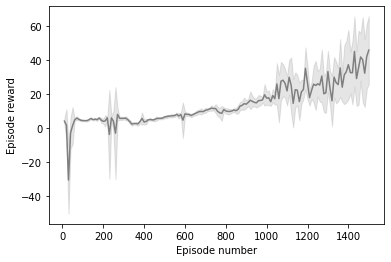

In [7]:
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")

env_with_Dead = True
max_action = float(env.action_space.high[0])
kwargs = { 
    "env_with_Dead":env_with_Dead,
    "state_dim": obs_dim,
    "action_dim": act_dim,
    "max_action": max_action,
    "gamma": 0.99,
    "net_width": 300,
    "a_lr": 5e-4,
    "c_lr": 5e-4,
    "Q_batchsize":256}
# initialise agent
agent = Agent(**kwargs)
replay_buffer = ReplayBuffer(obs_dim, act_dim, max_size=int(1e6))
max_episodes = 1500
max_timesteps = 2000
save_interval = 500
render = False
# load = True
# ModelIdex = 100
# if load: agent.load(ModelIdex)
# training procedure:
for episode in range(1, max_episodes+1):
    state, done = env.reset(), False
    # for t in range(max_timesteps):
    while not done:
      if render:
        action = agent.sample_action(state)
        next_state, reward, done, _ = env.step(action)
        env.render()
      else:
        # select the agent action
        action = agent.sample_action(state)

        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)
        
        if reward <= -100:
            reward = -1
            replay_buffer.add(state, action, reward, next_state, True)
        else:
            replay_buffer.add(state, action, reward, next_state, False)

        if replay_buffer.size > 2000: agent.train(replay_buffer)

        # stop iterating when the episode finished
        if done:
          break

      state = next_state
      ep_reward += reward
    
    if (episode+1)%save_interval==0:
        agent.save(episode + 1)
    
    # append the episode reward to the reward list
    reward_list.append(ep_reward)

    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0
    
    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)
 


In [8]:
!zip -r /content/code.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.02.02/ (stored 0%)
  adding: content/.config/logs/2023.02.02/14.39.58.825595.log (deflated 86%)
  adding: content/.config/logs/2023.02.02/14.39.31.829528.log (deflated 58%)
  adding: content/.config/logs/2023.02.02/14.39.06.001578.log (deflated 91%)
  adding: content/.config/logs/2023.02.02/14.40.36.103035.log (deflated 56%)
  adding: content/.config/logs/2023.02.02/14.40.07.359558.log (deflated 58%)
  adding: content/.config/logs/2023.02.02/14.40.35.179271.log (deflated 57%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.confi

In [10]:
from google.colab import files

In [12]:
files.download('/content/code.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>